# Probabilistic Forecasting: Quantile Regression



Quantile regression is a technique for estimating the conditional quantiles of a response variable. By combining the predictions of two quantile regressors, an interval can be constructed, where each model estimates one of the interval’s boundaries. For example, models trained for $Q = 0.1$ and $Q = 0.9$ produce an 80% prediction interval ($90\% - 10\% = 80\%$).

If a machine learning algorithm capable of modeling quantiles is used as the `regressor` in a forecaster, the `predict` method will return predictions for a specified quantile. By creating two forecasters, each configured with a different quantile, their predictions can be combined to generate a prediction interval.

As opposed to linear regression, which is intended to estimate the conditional mean of the response variable given certain values of the predictor variables, quantile regression aims at estimating the conditional quantiles of the response variable. For a continuous distribution function, the $\alpha$-quantile $Q_{\alpha}(x)$ is defined such that the probability of $Y$ being smaller than $Q_{\alpha}(x)$ is, for a given $X=x$, equal to $\alpha$. For example, 36% of the population values are lower than the quantile  $Q=0.36$. The most known quantile is the 50%-quantile, more commonly called the median.

By combining the predictions of two quantile regressors, it is possible to build an interval. Each model estimates one of the limits of the interval. For example, the models obtained for $Q = 0.1$ and $Q = 0.9$ produce an 80% prediction interval (90% - 10% = 80%).

Several machine learning algorithms are capable of modeling quantiles. Some of them are:

+ [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

+ [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

+ [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

+ [Scikit-learn HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

+ [Scikit-learn QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

+ [skranger quantile RandomForest](https://skranger.readthedocs.io/en/stable/index.html)


Just as the squared-error loss function is used to train models that predict the mean value, a specific loss function is needed in order to train models that predict quantiles. The most common metric used for quantile regression is calles [quantile loss  or pinball loss](https://en.wikipedia.org/wiki/Quantile_regression):


$$\text{pinball}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1}  \alpha \max(y_i - \hat{y}_i, 0) + (1 - \alpha) \max(\hat{y}_i - y_i, 0)$$

where $\alpha$ is the target quantile, $y$ the real value and $\hat{y}$ the quantile prediction.

It can be seen that loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates, and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, are that each quantile needs its regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using [ForecasterDirect](../api/forecasterdirect.html) and [ForecasterDirectMultiVariate](../api/forecasterdirectmultivariate.html) models.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Forecasters of type <code>ForecasterDirect</code> are slower than <code>ForecasterRecursive</code> because they require training one model per step. Although they can achieve better performance, their scalability is an important limitation when many steps need to be predicted. To limit the time required to run the following examples, the data is aggregated from hourly frequency to daily frequency and only 7 steps ahead (one week) are predicted.

</div>

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.metrics import create_mean_pinball_loss

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Data
# ==============================================================================
data = fetch_dataset(name='ett_m2')
data = data[['OT']]
data.head(2)

ett_m2
------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL).
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).
https://github.com/zhouhaoyi/ETDataset
Shape of the dataset: (69680, 7)


,OT
date,
2016-07-01 00:00:00,38.661999
2016-07-01 00:15:00,38.223000


In [3]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cliclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                        variables     = features_to_encode,
                        max_values    = max_values,
                        drop_original = True
                   )

exog_transformer = make_pipeline(
                        calendar_transformer,
                        cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
exog_features = data.columns.difference(['OT']).tolist()
display(data.head(3))

Pipeline(steps=[('datetimefeatures',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract=['year', 'month', 'week',
                                                       'day_of_week', 'hour'],
                                  variables='index')),
                ('cyclicalfeatures',
                 CyclicalFeatures(drop_original=True,
                                  max_values={'day_of_week': 7, 'hour': 24,
                                              'month': 12, 'week': 52},
                                  variables=['month', 'week', 'day_of_week',
                                             'hour']))])

,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,
2016-07-01 00:00:00,38.661999,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:15:00,38.223000,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:30:00,37.344002,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0


In [4]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-10-01 23:59:00'
end_validation = '2018-04-03 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 00:00:00 --- 2017-10-01 23:45:00  (n=43968)
Dates validacion : 2017-10-02 00:00:00 --- 2018-04-03 23:45:00  (n=17664)
Dates test       : 2018-04-04 00:00:00 --- 2018-06-26 19:45:00  (n=8048)


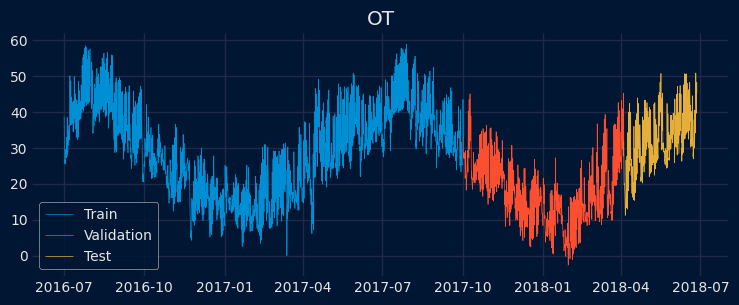

In [5]:
# Plot partitions
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('OT')
ax.legend();

Two quantile forecasters are trained, one for the 10% quantile and another for the 90% quantile. The predictions of both forecasters can be combined to generate a prediction interval of 80% coverage.

In [6]:
# Create forecasters: one for each bound of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.1,
                                     verbose       = -1
                                 ),
                     lags  = [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73],
                     steps = 24
                 )
                  
# Forecaster for quantile 90%
forecaster_q90 = ForecasterDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.9,
                                     verbose       = -1
                                 ),
                     lags  = [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73],
                     steps = 24
                 )

Next, a bayesian search is performed to find the best hyperparameters for the quantile regressors. When validating a quantile regression model, it is important to use a metric that is coherent with the quantile being evaluated. In this case, the pinball loss is used. Skforecast provides the function `create_mean_pinball_loss` calculate the pinball loss for a given quantile.

In [7]:
# Bayesian search of hyper-parameters and lags for each quantile forecaster
# ==============================================================================
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.1)
    }

    return search_space

cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data[:end_train]),
        refit              = False,
    )

results_grid_q10 = bayesian_search_forecaster(
                       forecaster     = forecaster_q10,
                       y              = data.loc[:end_validation, 'OT'],
                       cv             = cv,
                       metric         = create_mean_pinball_loss(alpha=0.1),
                       search_space   = search_space,
                       n_trials       = 10,
                       random_state   = 123,
                       return_best    = True,
                       n_jobs         = 'auto',
                       verbose        = False,
                       show_progress  = True
                   )

results_grid_q90 = bayesian_search_forecaster(
                       forecaster    = forecaster_q90,
                       y             = data.loc[:end_validation, 'OT'],
                       cv            = cv,
                       metric        = create_mean_pinball_loss(alpha=0.9),
                       search_space  = search_space,
                       n_trials      = 10,
                       random_state  = 123,
                       return_best   = True,
                       n_jobs        = 'auto',
                       verbose       = False,
                       show_progress = True
                   )

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49 71 72 73] 
  Parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.04040638127771271}
  Backtesting metric: 0.41020051875078


  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49 71 72 73] 
  Parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.061491327557080706}
  Backtesting metric: 0.350142766138876


### Predictions (backtesting)

Once the quantile forecasters are trained, they can be used to predict each of the bounds of the forecasting interval.

In [8]:
# Backtesting on test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster    = forecaster_q10,
                                  y             = data['OT'],
                                  cv            = cv,
                                  metric        = create_mean_pinball_loss(alpha=0.1),
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster    = forecaster_q90,
                                  y             = data['OT'],
                                  cv            = cv,
                                  metric        = create_mean_pinball_loss(alpha=0.9),
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )
pred_intervals = pd.concat([predictions_q10, predictions_q90], axis=1)
pred_intervals.columns = ['lower_bound', 'upper_bound']
pred_intervals.head()

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

,lower_bound,upper_bound
2018-04-04 00:00:00,31.848286,32.268329
2018-04-04 00:15:00,31.563152,32.150039
2018-04-04 00:30:00,31.269266,32.271917
2018-04-04 00:45:00,31.081806,32.139591
2018-04-04 01:00:00,30.670913,32.049578


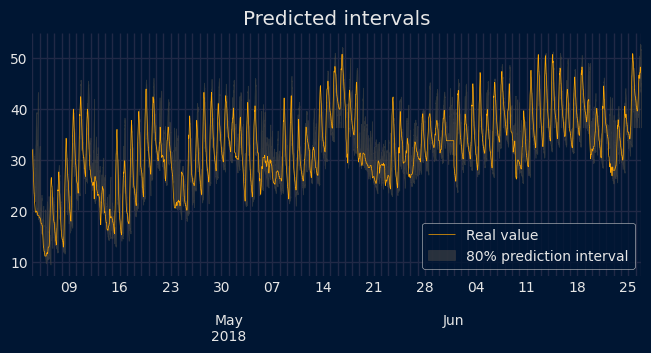

In [9]:
# Plot interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'OT'].plot(ax=ax, label='Real value', color='orange')
ax.fill_between(
    data.loc[end_validation:].index,
    pred_intervals['lower_bound'],
    pred_intervals['upper_bound'],
    color = '#444444',
    alpha = 0.6,
    zorder = 1,
    label = '80% prediction interval'
)
ax.set_xlabel('')
ax.set_title("Predicted intervals")
ax.legend();

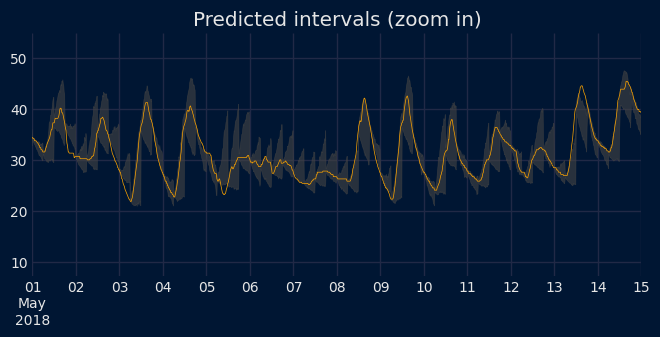

In [10]:
# Plot intervals with zoom ['2018-05-01', '2018-05-15']
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'OT'].plot(ax=ax, label='Real value', color='orange')
ax.fill_between(
    data.loc[end_validation:].index,
    pred_intervals['lower_bound'],
    pred_intervals['upper_bound'],
    color = '#444444',
    alpha = 0.6,
    zorder = 1,
    label = '80% prediction interval'
)
ax.set_xlabel('')
ax.set_title("Predicted intervals (zoom in)");
ax.set_xlim(['2018-05-01', '2018-05-15']);

In [11]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'OT'],
    lower_bound = predictions_q10["pred"], 
    upper_bound = predictions_q90["pred"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_q90["pred"] - predictions_q10["pred"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 77.37 %
Area of the interval: 38980.18


The prediction intervals generated using conformal prediction achieve an empirical coverage close to the nominal coverage of 80%.